In [26]:
import librosa
import numpy as np
from birdnetlib import analyzer, Recording
import operator
import matplotlib.pyplot as plt
from scipy import signal,ndimage

Create the classifier.

In [27]:
an = analyzer.Analyzer(classifier_model_path=r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier.tflite",
                       classifier_labels_path=r"C:\Users\plaf\Music\ALAN_training\tytalb_hissing_cclassifier_Labels.txt")


load_custom_models
Custom model loaded.
loading custom classifier labels
Labels loaded.
load model False
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.


Some manually defined variables 

In [28]:

af_path = r"c:\Users\plaf\Music\ALAN_training\audiofiles\87_MuristHautDing_20230627_220000.WAV"
# rec = Recording(an, af_path)
dur = 21
dur_birdnet = 3
subseg_dur = .75
margin = .2
min_dur = .5
tstart = 300


Load samples and compute the power spectrogram.
Get the power in time by summing each column of the spectrogram.
Then smooth the power values by applying a gaussian filter.

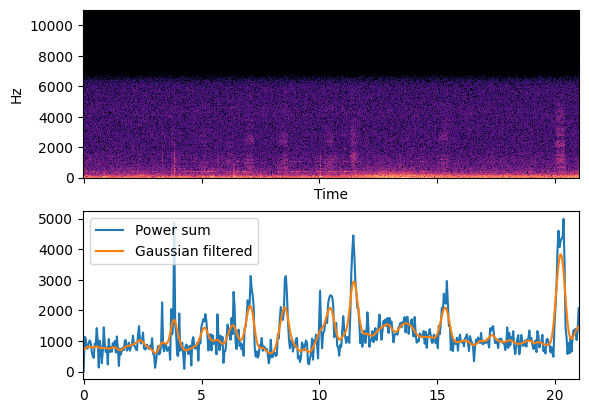

In [46]:

y, sr = librosa.load(af_path, sr=48000, mono=True, res_type="kaiser_fast", offset = tstart, duration=dur)
sample_subseg_dur = int(subseg_dur * sr)
sample_dur = int(dur * sr)
sample_dur_birdnet = int(dur_birdnet * sr)

n_fft = 2048
hop_length = n_fft
S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
spec = librosa.amplitude_to_db(np.abs(S))
spec_sum = np.sum(spec, axis=0)

l = spec_sum
spec_sum -= np.min(spec_sum)
conv = ndimage.gaussian_filter1d(spec_sum, 2)

# Utilities to plot functions easily
tstamps_arr = lambda arr: np.linspace(0, dur, len(arr))
plot_vals = lambda arr: (tstamps_arr(arr), arr)

spec_tstamps = tstamps_arr(spec.T)



fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].plot(*plot_vals(spec_sum), label="Power sum")
ax[1].plot(*plot_vals(conv), label="Gaussian filtered")
ax[1].legend()
plt.show()

Find the local minima (valleys) and maxima (summits) on the filtered function.  Make sure that there is always a local minima before and after a local maxima by "artificially creating" one at the start and at the end of the audio portion in case the power spectrogram curve sarts, resp ends, with a local maximum.

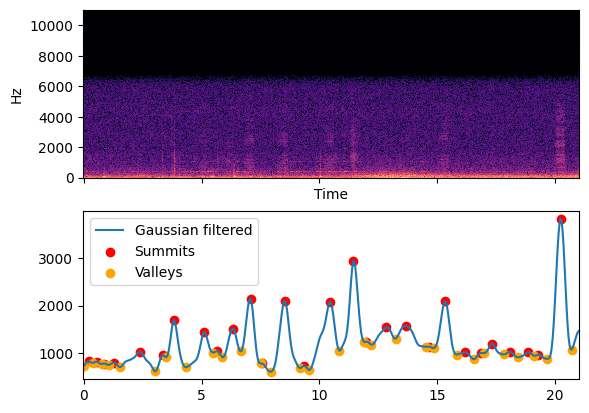

In [47]:
summit = np.zeros_like(conv, dtype=np.bool_)
 # "<" guarantees the existance of only one point in the neighborhood
summit[1:-1] = (conv[:-2] < conv[1:-1]) & (conv[1:-1] >= conv[2:])
summit_i = np.flatnonzero(summit)

valley = np.zeros_like(summit)
# ">" as above
valley[1:-1] = (conv[:-2] > conv[1:-1]) & (conv[1:-1] <= conv[2:])
valley_i = np.flatnonzero(valley)

# "pre-/append" valley 
valley[0] = summit_i[0] < valley_i[0]
valley[-1] = summit_i[-1] > valley_i[-1]

valley_i = np.flatnonzero(valley)


fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].plot(*plot_vals(conv), label="Gaussian filtered")
ax[1].scatter(tstamps_arr(conv)[summit], conv[summit], c="red", label="Summits")
ax[1].scatter(tstamps_arr(conv)[valley], conv[valley], c="orange", label="Valleys")
ax[1].legend()
plt.show()

Identify the start and the end of the calls by getting the steepest local points, i.e. local minima and maxima of the "first derivative" (finite difference). The starts would correspond to the local maxima (`dsummit`) and the ends to the minima (`dvalley`).

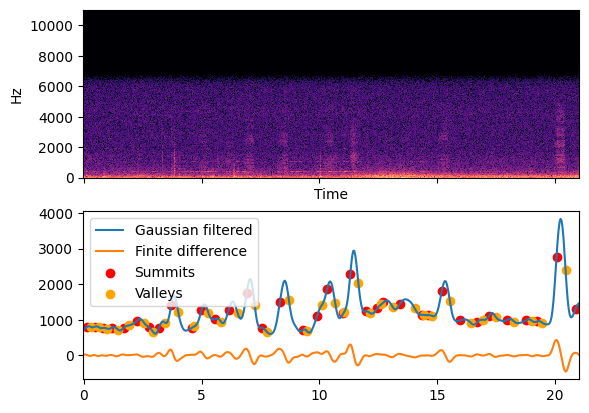

In [64]:

dconv = np.diff(conv)

dsummit = np.zeros_like(summit)
dsummit[2:-1] = (dconv[:-2] < dconv[1:-1]) & (dconv[1:-1] >= dconv[2:])
dsummit_i = np.flatnonzero(dsummit)

dsummit[1] = summit_i[0] < dsummit_i[0]

dvalley = np.zeros_like(summit)
dvalley[2:-1] = (dconv[:-2] > dconv[1:-1]) & (dconv[1:-1] <= dconv[2:])
dvalley_i = np.flatnonzero(dvalley)

dvalley[-2] = summit_i[-1] > dvalley_i[-1]

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].plot(*plot_vals(conv), label="Gaussian filtered")
ax[1].plot(*plot_vals(dconv), label="Finite difference")
ax[1].scatter(tstamps_arr(conv)[dsummit], conv[dsummit], c="red", label="Summits")
ax[1].scatter(tstamps_arr(conv)[dvalley], conv[dvalley], c="orange", label="Valleys")
ax[1].legend()
plt.show()

Reduce the power sum in the interval between the previous and the next `valley` by the mean of the two. Set the threshold as the mean of the reduced `summit` values, here called `spikes`.

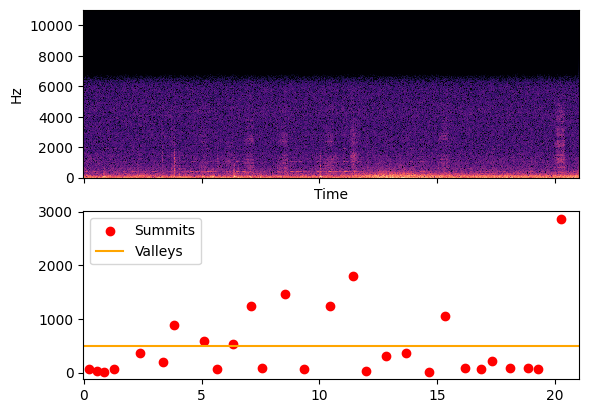

In [66]:

previous_valley = conv[valley_i[:-1]]
next_valley = conv[valley_i[1:]]
d = np.stack([previous_valley, next_valley])
spikes = conv[summit] - np.mean(d, axis=0)
thresh = np.mean(spikes)

fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.specshow(spec, x_coords = spec_tstamps, x_axis='time', y_axis='linear', ax=ax[0])
ax[1].scatter(tstamps_arr(conv)[summit], spikes, c="red", label="Summits")
ax[1].axhline(thresh, c="orange", label="Threshold")
ax[1].legend()
plt.show()


In [ ]:

sample_start_mask = np.zeros_like(y, dtype=np.bool_)
sample_start_mask[valley_i[:-1][spikes > thresh]] = True
sample_start_i = np.flatnonzero(sample_start_mask)
sample_end_mask = np.zeros_like(sample_start_mask)
sample_end_mask[valley_i[1:][spikes > thresh]] = True
sample_end_i = np.flatnonzero(sample_end_mask)
for i, (ssi, sei) in enumerate(zip(sample_start_i, sample_end_i)):
    dconv_ = dconv[ssi:sei]
    sample_start_i[i] = ssi + np.argmax(dconv_)
    sample_end_i[i] = ssi + np.argmin(dconv_)
    ax[1].plot(times_plot[ssi:sei], dconv_)





dsummit_i = np.flatnonzero(dsummit)
print(len(summit_i), len(dsummit_i), len(dvalley_i))
dvalley_i = np.flatnonzero(dvalley)

px_to_sample = len(y) / len(conv)

subseg_starts = ((sample_start_i) * px_to_sample - margin * sr).astype(np.int64)
subseg_ends =  ((sample_end_i) * px_to_sample + margin * sr).astype(np.int64)



l = len(y)
times_plot = np.linspace(0, dur, l)

ax[1].vlines(times_plot[np.delete(subseg_starts, subseg_starts>len(times_plot))], conv.min(), conv.max(), colors="red")
ax[1].vlines(times_plot[np.delete(subseg_ends, subseg_ends>len(times_plot))], conv.min(), conv.max(), colors="green")
# plt.xlim([6,8])
plt.show()

plt.close()


valid_starts = []
valid_ends = []

np.random.seed(42)
white_noise = np.random.normal(np.mean(y), np.std(y), size=sr * dur_birdnet)

for ss, se in zip(subseg_starts, subseg_ends):
    y_subseg = np.array(white_noise)
    dur = (se-ss) / sr



    
    if dur > dur_birdnet:
        # Make sure that the duration is not longer than BirdNET allows
        center = (se + ss) // 2
        ss = sample_dur_birdnet // 2
        se = ss + sample_dur_birdnet

    y_ = y[ss: se]
    center = int(sample_dur_birdnet // 2)
    l_half = int(len(y_) // 2)
    start = center - l_half
    print(len(y_), len(y_subseg))
    y_subseg[start: start + len(y_)] = y_
    pred = an.predict_with_custom_classifier(y_subseg)[0]

    # Assign scores to labels
    p_labels = dict(zip(an.labels, pred))

    # Sort by score
    p_sorted = sorted(
        p_labels.items(), key=operator.itemgetter(1), reverse=True
    )
    print(p_sorted)

    # Filter by recording.minimum_confidence so not to needlessly store full 8K array for each chunk.
    conf_thresh = .9
    p_sorted = [i for i in p_sorted if i[1] >= conf_thresh]
    if p_sorted:
        print("Taken", dur)
        valid_starts.append(ss)
        valid_ends.append(se)

fig, ax = plt.subplots(nrows=2, sharex=True)
times_spec = np.linspace(0, dur, spec.shape[1])
librosa.display.specshow(spec, x_coords = times_spec, x_axis='time', y_axis='linear', ax=ax[0])

l = len(y)
times_plot = np.linspace(0, dur, l)
plt.plot(times_plot, y)
plt.vlines(times_plot[valid_starts], y.min(), y.max(), colors="red")
# plt.vlines(100, y.min(), y.max(), colors="red")
plt.vlines(times_plot[valid_ends], y.min(), y.max(), colors="green")
plt.show()



In [ ]:
spec_sum -= np.min(spec_sum)
conv = ndimage.gaussian_filter1d(spec_sum, 2)
# conv = ndimage.gaussian_filter1d(conv, 10)

summit = np.zeros_like(conv, dtype=np.bool_)
 # "<" guarantees the existance of only one point in the neighborhood
summit[1:-1] = (conv[:-2] < conv[1:-1]) & (conv[1:-1] >= conv[2:])
summit_i = np.flatnonzero(summit)

valley = np.zeros_like(summit)
valley[1:-1] = (conv[:-2] > conv[1:-1]) & (conv[1:-1] <= conv[2:])
valley_i = np.flatnonzero(valley)

valley[0] = summit_i[0] < valley_i[0]
valley[-1] = summit_i[-1] > valley_i[-1]

valley_i = np.flatnonzero(valley)





fig, ax = plt.subplots(nrows=2, sharex=True)

times_spec = np.linspace(0, dur, spec.shape[1])

librosa.display.specshow(spec, x_coords = times_spec, x_axis='time', y_axis='linear', ax=ax[0])

l = len(conv)
times_plot = np.linspace(0, dur, l)
pow_threshold = np.mean(conv)

# ax[1].plot(times_plot, conv)
ax[1].plot(times_plot, [pow_threshold]*l)
# ax[1].scatter(times_plot[dsummit_i], conv[dsummit_i]) 
# ax[1].scatter(times_plot[dvalley_i], conv[dvalley_i])
ax[1].scatter(times_plot[summit_i], conv[summit_i])
ax[1].scatter(times_plot[valley_i], conv[valley_i])


# ax[1].scatter(times_plot[previous_valley], conv[previous_valley])

# ax[1].scatter(times_plot[next_dvalley], conv[next_dvalley])
d = np.stack([previous_valley, next_valley])
spikes = conv[summit] - np.mean(d, axis=0)
# spikes[0] -= spikes[1]
# spikes[1:-1] -= (spikes[:-2] + spikes[2:])/2
# spikes[-1] -= spikes[-2]
ax[1].scatter(times_plot[summit_i], spikes)

half_back = sample_subseg_dur // 2

dconv = np.diff(conv)

dsummit = np.zeros_like(summit)
dsummit[2:-1] = (dconv[:-2] > dconv[1:-1]) & (dconv[1:-1] <= dconv[2:])
dsummit_i = np.flatnonzero(dsummit)

dsummit[1] = summit_i[0] < dsummit_i[0]

dvalley = np.zeros_like(summit)
dvalley[2:-1] = (dconv[:-2] < dconv[1:-1]) & (dconv[1:-1] >= dconv[2:])
dvalley_i = np.flatnonzero(dvalley)

dvalley[-2] = summit_i[-1] > dvalley_i[-1]


thresh = np.mean(spikes)
ax[1].plot(times_plot, [thresh]*len(conv))
sample_start_mask = np.zeros_like(y, dtype=np.bool_)
sample_start_mask[valley_i[:-1][spikes > thresh]] = True
sample_start_i = np.flatnonzero(sample_start_mask)
sample_end_mask = np.zeros_like(sample_start_mask)
sample_end_mask[valley_i[1:][spikes > thresh]] = True
sample_end_i = np.flatnonzero(sample_end_mask)
for i, (ssi, sei) in enumerate(zip(sample_start_i, sample_end_i)):
    dconv_ = dconv[ssi:sei]
    sample_start_i[i] = ssi + np.argmax(dconv_)
    sample_end_i[i] = ssi + np.argmin(dconv_)
    ax[1].plot(times_plot[ssi:sei], dconv_)





dsummit_i = np.flatnonzero(dsummit)
print(len(summit_i), len(dsummit_i), len(dvalley_i))
dvalley_i = np.flatnonzero(dvalley)



# ax[1].plot([np.median(conv)] * len(conv) )
# subseg_starts = ((np.flatnonzero(summit & (conv[1:-1] > pow_threshold)) + 1) * px_to_sample).astype(np.int64) - int(sample_subseg_dur / 2)

px_to_sample = len(y) / len(conv)

# sample_start_mask = np.zeros_like(y, dtype=np.bool_)
# sample_start_mask[dvalley_i[spikes > thresh]] = True
# sample_start_i = np.flatnonzero(sample_start_mask)
# sample_end_mask = np.zeros_like(sample_start_mask)
# sample_end_mask[dsummit_i[spikes > thresh]] = True
# sample_end_i = np.flatnonzero(sample_end_mask)


subseg_starts = ((sample_start_i) * px_to_sample - margin * sr).astype(np.int64)
subseg_ends =  ((sample_end_i) * px_to_sample + margin * sr).astype(np.int64)



l = len(y)
times_plot = np.linspace(0, dur, l)

ax[1].vlines(times_plot[np.delete(subseg_starts, subseg_starts>len(times_plot))], conv.min(), conv.max(), colors="red")
ax[1].vlines(times_plot[np.delete(subseg_ends, subseg_ends>len(times_plot))], conv.min(), conv.max(), colors="green")
# plt.xlim([6,8])
plt.show()

plt.close()


valid_starts = []
valid_ends = []

np.random.seed(42)
white_noise = np.random.normal(np.mean(y), np.std(y), size=sr * dur_birdnet)

for ss, se in zip(subseg_starts, subseg_ends):
    y_subseg = np.array(white_noise)
    dur = (se-ss) / sr



    
    if dur > dur_birdnet:
        # Make sure that the duration is not longer than BirdNET allows
        center = (se + ss) // 2
        ss = sample_dur_birdnet // 2
        se = ss + sample_dur_birdnet

    y_ = y[ss: se]
    center = int(sample_dur_birdnet // 2)
    l_half = int(len(y_) // 2)
    start = center - l_half
    print(len(y_), len(y_subseg))
    y_subseg[start: start + len(y_)] = y_
    pred = an.predict_with_custom_classifier(y_subseg)[0]

    # Assign scores to labels
    p_labels = dict(zip(an.labels, pred))

    # Sort by score
    p_sorted = sorted(
        p_labels.items(), key=operator.itemgetter(1), reverse=True
    )
    print(p_sorted)

    # Filter by recording.minimum_confidence so not to needlessly store full 8K array for each chunk.
    conf_thresh = .9
    p_sorted = [i for i in p_sorted if i[1] >= conf_thresh]
    if p_sorted:
        print("Taken", dur)
        valid_starts.append(ss)
        valid_ends.append(se)

fig, ax = plt.subplots(nrows=2, sharex=True)
times_spec = np.linspace(0, dur, spec.shape[1])
librosa.display.specshow(spec, x_coords = times_spec, x_axis='time', y_axis='linear', ax=ax[0])

l = len(y)
times_plot = np.linspace(0, dur, l)
plt.plot(times_plot, y)
plt.vlines(times_plot[valid_starts], y.min(), y.max(), colors="red")
# plt.vlines(100, y.min(), y.max(), colors="red")
plt.vlines(times_plot[valid_ends], y.min(), y.max(), colors="green")
plt.show()

